In [35]:
! pip install langchain langchain_community tiktoken chromadb==0.5.3 langchain langchain-ollama langchain-nomic[local] sentence_transformers


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [36]:
import os
import dotenv

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
path = './.env'
os.environ['LANGCHAIN_API_KEY'] = dotenv.get_key(path, key_to_get='LANGCHAIN_API_KEY') if dotenv.load_dotenv(dotenv_path=path) else input('Langchain api key: ')
os.environ['LANGCHAIN_PROJECT'] = "basic-rag-agent"

In [116]:
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import chromadb.utils.embedding_functions as embedding_functions
import chromadb

# Load and split the document.
panda_doc = TextLoader('./pandas.txt').load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=200)
splits = text_splitter.split_documents(panda_doc)

# Extract text from Document because Chroma only works with text.
splits = map(lambda d: d.page_content, splits)
splits = list(splits)

# Create an Ollama embedding function and Chroma collection with the function to splits.
ollama_ef = embedding_functions.OllamaEmbeddingFunction(url="http://localhost:11434/api/embeddings", 
                                                        model_name="llama3.1",)
chroma_client = chromadb.Client()
collection = chroma_client.create_collection(name="panda_collection", embedding_function=ollama_ef, get_or_create=True)
# Each split document requires a unique 'id', for simplicity have each id be a string 'id' with a number.
collection.add(ids=["id" + str(i) for i in range(len(splits))], documents=splits)

Insert of existing embedding ID: id0
Insert of existing embedding ID: id1
Insert of existing embedding ID: id2
Insert of existing embedding ID: id3
Insert of existing embedding ID: id4
Insert of existing embedding ID: id5
Insert of existing embedding ID: id6
Insert of existing embedding ID: id7
Insert of existing embedding ID: id8
Insert of existing embedding ID: id9
Insert of existing embedding ID: id10
Insert of existing embedding ID: id11
Insert of existing embedding ID: id12
Insert of existing embedding ID: id13
Insert of existing embedding ID: id14
Insert of existing embedding ID: id15
Insert of existing embedding ID: id16
Insert of existing embedding ID: id17
Insert of existing embedding ID: id18
Insert of existing embedding ID: id19
Insert of existing embedding ID: id20
Insert of existing embedding ID: id21
Insert of existing embedding ID: id22
Insert of existing embedding ID: id23
Insert of existing embedding ID: id24
Insert of existing embedding ID: id25
Insert of existing emb

In [55]:
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"]
)

llm = ChatOllama(model="llama3.1", temperature=0)
#This is the overall chain that will run the the llm. 
rag_chain = prompt | llm | StrOutputParser()


In [56]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

llm = ChatOllama(model="llama3.1", format="json", temperature=0)

prompt = PromptTemplate(template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"]
)

# Will task the llm to read through the give state's docs to score their relevance with yes/no.
# This score will be in JSON formay wtih the key score.
retrieval_grader = prompt | llm | JsonOutputParser()



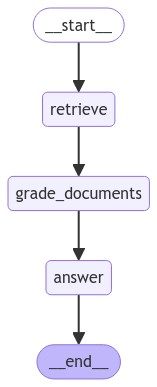

In [117]:
from typing_extensions import TypedDict, List
from IPython.display import Image, display
from langgraph.graph import END, StateGraph

class GraphState(TypedDict):
    """
        The state of the  graph.
        
        State Attributes:
            question: question
            generation: LLM generation
            documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
    steps: List[str]

def retrieve(state):
    """
        Get Documents

        Args:
            state: Current Graph State
        
        Returns:
            state: with the retrieved added into the state's documents attribute
    """
    question = state["question"]
    documents = collection.query(query_texts=question)["documents"]
    steps = state["steps"]
    steps.append("get_documents")
    return {"documents": documents, "question": question, "steps":steps}

def answer(state):
    """
        Final answer to the question

        Args:
            state: Current Graph State
        
        Returns:
            state: with generated answer in the genration attribute            
    """
    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"question":question,"documents":documents})
    steps = state["steps"]
    steps.append("generate_answer")
    return {"question":question, "generation":generation, "documents":documents, "steps":steps}

def grade_documents(state):
    """
        Final answer to the question

        Args:
            state: Current Graph State
        
        Returns:

            state: with state's documents contain most relevant documents
    """
    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    # Calls retrival_grader on the given document to retrive the JSON grade.
    get_grade = lambda document: retrieval_grader.invoke({"question":question, "document": document}) 
    # Holds relevant documents where the JSON score is 'yes'.
    filtered_docs = [d for d in documents if get_grade(d)['score'] == 'yes']
    return {
        "documents" : filtered_docs,
        "question" : question,
        "steps" : steps
    }
    
# Graph
workflow = StateGraph(GraphState)

# Nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("answer",answer)

# Edges
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve","grade_documents")
workflow.add_edge("grade_documents","answer")
workflow.add_edge("answer",END)

custom_graph = workflow.compile()
display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))


In [98]:
import uuid

def predict_custom_agent_answer(example: dict):
    config = {"configurable" : {"thread_id": str(uuid.uuid4())}}

    state_dict = custom_graph.invoke({"question": example["input"], "steps": [],}, config)
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}
example = {"input": "What do pandas eat?"}

In [118]:
response = predict_custom_agent_answer(example)
response["response"]

'Giant pandas primarily eat bamboo, which makes up almost their entire diet. They also occasionally eat other plants, such as grasses and wild fruit, but bamboo is their main source of nutrition. In captivity, they may be given specially formulated biscuits or supplements to supplement their diet.'